 In this notebook I train a Gaussian Naive Bayes model to predict which class [quarry blast, earthquake, or MIS] an event belongs to based on 12 features computed by Keith and Relu.

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load in the data

In [2]:
# '\s+' tells pandas to use any spaces as the delimiter instead of ,
original_data = pd.read_csv("../data/delivery.2023.03.12.dat", delimiter='\s+')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3328590/4163960611.py:2: SyntaxWarning: invalid escape sequence '\s'
  original_data = pd.read_csv("../data/delivery.2023.03.12.dat", delimiter='\s+')


In [3]:
# Look at the ranges of the values
original_data.describe()

,Lat,Lon,Dep,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
count,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000
mean,39.848418,-111.784780,5.691582,-0.083785,0.375026,0.317479,-107.148297,-119.706056,15.235511,14.754784,-0.467517,-0.360643,-0.298032,0.165004,0.327487
std,1.246586,1.010628,6.927491,0.248041,0.352944,0.321559,18.825199,18.197792,1.178096,0.994258,0.172655,0.175630,0.198478,0.215352,0.219393
min,36.773000,-114.021000,-3.340000,-1.520000,-0.890000,-1.310000,-170.700000,-183.900000,11.860000,11.460000,-0.990000,-0.990000,-0.990000,-0.330000,-0.140000
25%,39.410000,-112.196000,-1.560000,-0.260000,0.170000,0.120000,-119.600000,-131.600000,14.250000,14.310000,-0.580000,-0.470000,-0.420000,0.000000,0.160000
50%,40.493000,-112.056000,7.040000,-0.040000,0.410000,0.340000,-107.700000,-121.400000,15.440000,14.970000,-0.470000,-0.370000,-0.310000,0.130000,0.280000
75%,40.746000,-111.323000,9.850000,0.080000,0.610000,0.530000,-94.200000,-108.100000,16.180000,15.410000,-0.370000,-0.260000,-0.200000,0.320000,0.470000
max,42.424000,-108.894000,55.750000,1.450000,2.730000,2.040000,-44.600000,-64.100000,17.790000,17.700000,0.470000,0.410000,0.420000,1.030000,1.220000


# Get features and labels

In [4]:
feature_col_names = ['F1', 'F2', 'F3', 'F4',
       'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12']
X_df = original_data[feature_col_names]

In [5]:
# LabelEncoder will transform the class names to numeric values
le = LabelEncoder()
le.fit(original_data['Tag'])
print("Original Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
le.classes_ = np.array(['ex', 'eq', 'mis'])
print("Updated Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
y = le.transform(original_data['Tag'])
y_cnts = np.unique(y, return_counts=True)[1]
print(y_cnts)

Original Classes ['eq' 'ex' 'mis']
Mapping [0 1 2]
Updated Classes ['ex' 'eq' 'mis']
Mapping [0 1 2]
[279 814 228]


# Do a simple 80/20 train/test split

In [6]:
train_inds, test_inds = train_test_split(np.arange(X_df.shape[0]), 
                                         test_size=0.2, 
                                         shuffle=True, 
                                         random_state=42,
                                         stratify=y)

In [7]:
X_df = X_df.to_numpy()
X_train = X_df[train_inds]
X_test = X_df[test_inds]
y_train = y[train_inds]
y_test = y[test_inds]

In [8]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (1056, 12) (1056,)
Testing: (265, 12) (265,)
Actual class percentage: [0.21120363 0.61619985 0.17259652]
Training class percentage: [0.21117424 0.61647727 0.17234848]
Testing class percentage: [0.21132075 0.61509434 0.17358491]


# Remove outliers in the training and testing sets 
remove rows with any features > 4 * the standard deviation of that feature in the training set

In [9]:
# n_stds = 4
# train_means = X_train.mean(axis=0)
# train_stds = X_train.std(axis=0)
# train_inds_to_drop = np.unique((np.concatenate([np.where(X_train >  train_means + n_stds*train_stds)[0],
#                                           np.where(X_train < train_means - n_stds*train_stds)[0]])))
# test_inds_to_drop = np.unique((np.concatenate([np.where(X_test >  train_means + n_stds*train_stds)[0],
#                                           np.where(X_test < train_means - n_stds*train_stds)[0]])))
# print(train_inds_to_drop, test_inds_to_drop)

low_percentile, high_percentile = np.percentile(X_train, [1, 99], axis=0)
train_inds_to_drop = np.unique((np.concatenate([np.where(X_train >  high_percentile)[0],
                                          np.where(X_train < low_percentile)[0]])))
test_inds_to_drop = np.unique((np.concatenate([np.where(X_test >  high_percentile)[0],
                                          np.where(X_test < low_percentile)[0]])))
print(train_inds_to_drop.shape, test_inds_to_drop.shape)

(164,) (42,)


In [10]:
filtered_train_inds = np.delete(train_inds, train_inds_to_drop)
filtered_test_inds = np.delete(test_inds, test_inds_to_drop)
X_train = X_df[filtered_train_inds]
X_test = X_df[filtered_test_inds]
y_train = y[filtered_train_inds]
y_test = y[filtered_test_inds]

In [11]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (892, 12) (892,)
Testing: (223, 12) (223,)
Actual class percentage: [0.21120363 0.61619985 0.17259652]
Training class percentage: [0.18273543 0.63789238 0.1793722 ]
Testing class percentage: [0.1838565  0.64573991 0.17040359]


# Train a Gaussian Naive Bayes model

In [12]:
nb = GaussianNB()

In [13]:
nb.fit(X_train, y_train)

GaussianNB()

In [14]:
y_pred_train = nb.predict(X_train)

In [15]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)

[[157   0   6]
 [  5 561   3]
 [  6   1 153]]


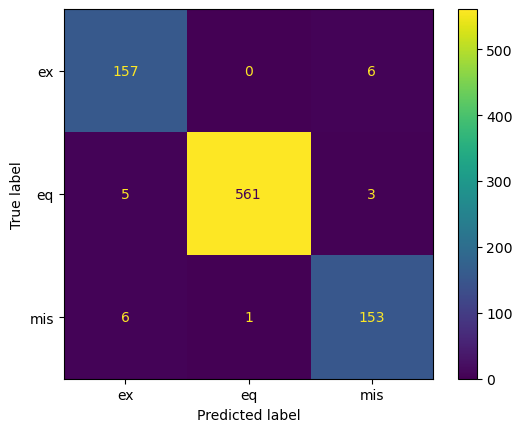

In [16]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

In [17]:
f1_score(y_train, y_pred_train, average='macro')

0.9636644942360664

# Evaluate the GNB model on the testing set
Use F1 score - which is the harmonic mean of precision and recall. `averaging="macro"` means that the F1 score for each of the classes is simply averaged. I chose this because I care about all the classes equally and don't want to give more weight to eq.

In [18]:
y_pred_test = nb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 39   0   2]
 [  0 143   1]
 [  0   2  36]]


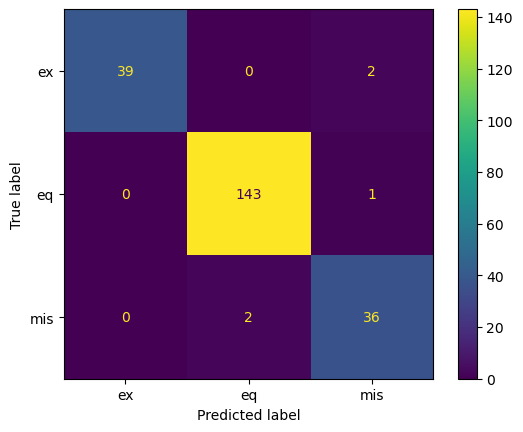

In [19]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

In [20]:
f1_score(y_test, y_pred_test, average='macro')

0.9665614374091883